<a href="https://colab.research.google.com/github/edwardoughton/GeoAI/blob/main/05_01_ggs590_geoai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Week 5 GeoAI: Spatial validity and trust in GeoAI outputs

Last week focused on software correctness. This week focuses on **geospatial correctness**.

Core question for today: **Are the spatial outputs scientifically and geographically valid?**

# Learning objectives

By the end of this class, students should be able to:

- Explain why passing unit tests does not guarantee spatial validity.
- Diagnose common geospatial validity failures (CRS, geometry, joins, measurement units).
- Apply spatial invariants to validate GeoAI workflow outputs.
- Debug a flawed end-to-end workflow and produce a defensible corrected result.
- Articulate what can be automated vs what still needs human geographic judgment.

# Class structure (2 hours)

- Part 1 (20 min): Why spatial validity is different
- Part 2 (40 min): Validation techniques and invariants
- Part 3 (45 min): Broken workflow debugging lab
- Part 4 (15 min): Meta discussion on limits of AI checking

## Setup

Run this once at the start. If a package is missing, uncomment and run the install cell.

In [1]:
# Optional installs (uncomment if needed)
# !pip install geopandas geodatasets pyproj shapely matplotlib


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_columns", 50)


## Download small datasets from the web

We use two lightweight public datasets:

- Natural Earth 110m countries
- TIGER cartographic boundary US states (20m)

These are small enough for class demos and exercises.

In [3]:
url_ne_countries = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
url_ne_places = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_populated_places_simple.zip"
url_tiger_states = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip"

world = gpd.read_file(url_ne_countries)
places = gpd.read_file(url_ne_places)
states = gpd.read_file(url_tiger_states)

print("world:", world.shape, world.crs)
print("places:", places.shape, places.crs)
print("states:", states.shape, states.crs)


world: (177, 169) EPSG:4326
places: (243, 32) EPSG:4326
states: (52, 10) EPSG:4269


## Part 1 (20 min): Why spatial validity is different

The code can run and still be spatially wrong. The next examples intentionally produce plausible-looking but incorrect outputs.

### Example A: Area calculation in geographic CRS (wrong) vs projected equal-area CRS (right)

If you compute area in EPSG:4326 (degrees), values are not meaningful in square meters.

In [4]:
# Keep contiguous US only for cleaner plotting
exclude = ["02", "15", "60", "66", "69", "72", "78"]
contig = states[~states["STATEFP"].isin(exclude)].copy()

# Wrong: area in geographic coordinates
contig["area_bad"] = contig.area

# Better: project to CONUS Albers equal area for measurement
contig_5070 = contig.to_crs(5070)
contig["area_sqkm"] = contig_5070.area / 1_000_000

contig[["NAME", "area_bad", "area_sqkm"]].head()


C:\Users\eoughton\AppData\Local\Temp\ipykernel_1236\1967997617.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contig["area_bad"] = contig.area


,NAME,area_bad,area_sqkm
0,Texas,65.778595,692662.976601
1,California,41.730153,410516.395909
2,Kentucky,10.665631,104630.073909
3,Georgia,14.682547,152734.373149
4,Wisconsin,16.512930,145561.389834


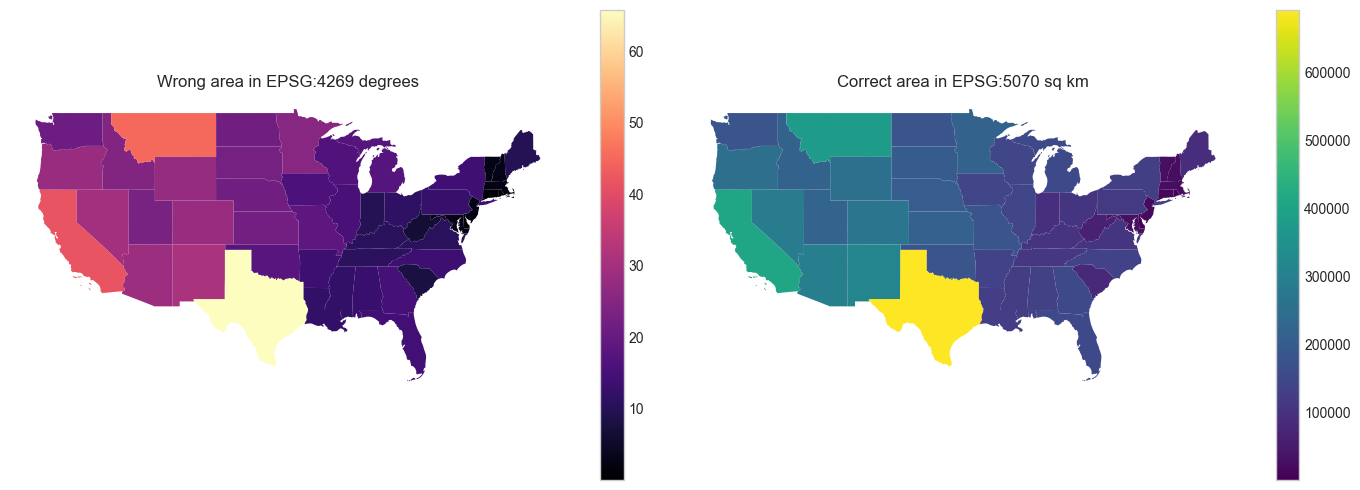

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

contig.plot(column="area_bad", ax=ax[0], legend=True, cmap="magma")
ax[0].set_title("Wrong area in EPSG:4269 degrees")
ax[0].set_axis_off()

contig.plot(column="area_sqkm", ax=ax[1], legend=True, cmap="viridis")
ax[1].set_title("Correct area in EPSG:5070 sq km")
ax[1].set_axis_off()

plt.tight_layout()


### 5-10 minute exercise 1

- Compute each state area in square miles (`sq_mi`).
- Find the 5 largest states by `sq_mi` (contiguous US only).
- Briefly explain why the ranking from `area_bad` is not trustworthy.

In [6]:
# Student exercise 1
# TODO: Create `sq_mi` from equal-area geometry
# TODO: Print top 5 states by sq_mi


### Example B: Buffer distance in degrees (wrong) vs meters (right)

A 1-degree buffer is not a fixed distance and should not be interpreted as 1 km or 1 mile.

C:\Users\eoughton\AppData\Local\Temp\ipykernel_1236\3271534459.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bad_buf["geometry"] = bad_buf.buffer(1)


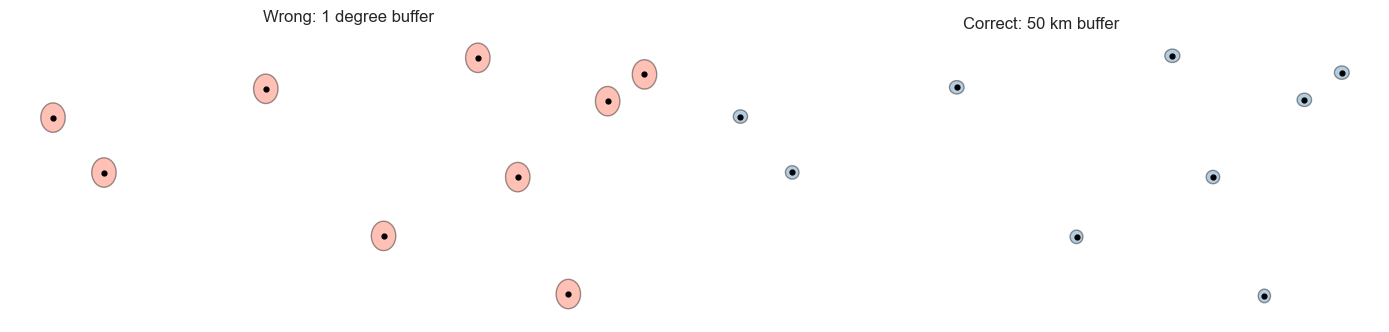

In [7]:
# Use a few US cities from Natural Earth populated places
us_places = places[places["adm0name"] == "United States of America"].copy()
us_places = us_places[["name", "geometry"]].head(10).copy()

# Wrong: buffering in geographic CRS (degrees)
bad_buf = us_places.copy()
bad_buf["geometry"] = bad_buf.buffer(1)

# Better: project to meters first, then buffer 50 km
us_places_5070 = us_places.to_crs(5070)
good_buf = us_places_5070.copy()
good_buf["geometry"] = good_buf.buffer(50_000)
good_buf = good_buf.to_crs(us_places.crs)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

bad_buf.plot(ax=ax[0], color="tomato", alpha=0.4, edgecolor="black")
us_places.plot(ax=ax[0], color="black", markersize=12)
ax[0].set_title("Wrong: 1 degree buffer")

good_buf.plot(ax=ax[1], color="steelblue", alpha=0.4, edgecolor="black")
us_places.plot(ax=ax[1], color="black", markersize=12)
ax[1].set_title("Correct: 50 km buffer")

for a in ax:
    a.set_axis_off()

plt.tight_layout()


### 5-10 minute exercise 2

- Build a **25 km** buffer around the same points.
- Plot points and buffers.
- In one sentence, state why this requires projected CRS.

In [8]:
# Student exercise 2
# TODO: Build 25 km buffer correctly
# TODO: Plot result


### Example C: Spatial join predicate choice changes meaning

`within`, `contains`, and `intersects` encode different spatial logic. A join can run and still be semantically wrong.

In [9]:
# Prepare points and polygons in same CRS
us_places = places[places["adm0name"] == "United States of America"].copy()
us_places = us_places[["name", "geometry"]].to_crs(states.crs)
state_polys = states[["NAME", "geometry"]].copy()

within_join = gpd.sjoin(us_places, state_polys, how="left", predicate="within")
intersects_join = gpd.sjoin(us_places, state_polys, how="left", predicate="intersects")

print("within null state matches:", within_join["NAME"].isna().sum())
print("intersects null state matches:", intersects_join["NAME"].isna().sum())


within null state matches: 0
intersects null state matches: 0


### 5-10 minute exercise 3

- Compare `within` vs `intersects` counts by state.
- Find one state where counts differ.
- Propose which predicate is more defensible for city-in-state assignment and why.

In [10]:
# Student exercise 3
# TODO: Group and compare counts by NAME for both predicates


## Part 2 (40 min): Spatial invariants for validity checks

Spatial invariants are conditions that should hold if outputs are valid.

### Invariant checklist

1. CRS appropriate for operation
2. Geometries valid and non-empty
3. Join match rates plausible
4. Measurements positive and within reasonable range
5. Intermediate maps do not show obvious artifacts

In [11]:
def validate_spatial_results(left_gdf, right_gdf, join_result=None, measurement_crs=None):
    """Minimal reusable validation helper for class exercises."""

    report = {}

    report["left_crs"] = str(left_gdf.crs)
    report["right_crs"] = str(right_gdf.crs)
    report["crs_match"] = left_gdf.crs == right_gdf.crs

    report["left_invalid_geoms"] = int((~left_gdf.is_valid).sum())
    report["right_invalid_geoms"] = int((~right_gdf.is_valid).sum())
    report["left_empty_geoms"] = int(left_gdf.is_empty.sum())
    report["right_empty_geoms"] = int(right_gdf.is_empty.sum())

    if measurement_crs is None:
        report["measurement_crs_provided"] = False
    else:
        report["measurement_crs_provided"] = True
        report["measurement_crs"] = measurement_crs

    if join_result is not None and "NAME" in join_result.columns:
        report["join_rows"] = int(len(join_result))
        report["join_unmatched_rows"] = int(join_result["NAME"].isna().sum())
        report["join_match_rate"] = float(1 - (join_result["NAME"].isna().mean()))

    return pd.Series(report)


In [12]:
# Run a quick validation example
example_join = gpd.sjoin(us_places, state_polys, how="left", predicate="within")
validate_spatial_results(us_places, state_polys, join_result=example_join, measurement_crs=5070)


left_crs                    EPSG:4269
right_crs                   EPSG:4269
crs_match                        True
left_invalid_geoms                  0
right_invalid_geoms                 0
left_empty_geoms                    0
right_empty_geoms                   0
measurement_crs_provided         True
measurement_crs                  5070
join_rows                           9
join_unmatched_rows                 0
join_match_rate                   1.0
dtype: object

### 5-10 minute exercise 4

- Extend `validate_spatial_results` with one extra check of your choice.
- Examples: duplicate IDs, impossible density values, area <= 0 count.
- Apply it to one of today's outputs.

In [13]:
# Student exercise 4
# TODO: Add one extra validation check to the function


## Part 3 (45 min): Broken workflow debugging lab

This workflow is intentionally flawed. Your job is to identify issues and produce a corrected output.

### Lab prompt

Goal: Count populated places per US state and compute place density (places per 10,000 sq km).

The broken version below includes multiple spatial validity problems.

In [14]:
# BROKEN WORKFLOW (intentional mistakes)

# 1) No US filter: includes all global places
lab_places = places.copy()

# 2) CRS mismatch during spatial join
lab_states_bad = states.to_crs(3857)
joined_bad = gpd.sjoin(lab_places, lab_states_bad[["NAME", "geometry"]], how="left", predicate="contains")

# 3) Area computed in wrong CRS
states["area_sqkm_bad"] = states.area / 1_000_000

# 4) Density from invalid numerator + invalid denominator
bad_counts = joined_bad.groupby("NAME").size().reset_index(name="place_count_bad")
lab_out_bad = states.merge(bad_counts, on="NAME", how="left")
lab_out_bad["place_count_bad"] = lab_out_bad["place_count_bad"].fillna(0)
lab_out_bad["density_bad"] = lab_out_bad["place_count_bad"] / (lab_out_bad["area_sqkm_bad"] / 10_000)

lab_out_bad[["NAME", "place_count_bad", "area_sqkm_bad", "density_bad"]].head()


C:\Users\eoughton\AppData\Local\Temp\ipykernel_1236\3607432904.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3857

  joined_bad = gpd.sjoin(lab_places, lab_states_bad[["NAME", "geometry"]], how="left", predicate="contains")
C:\Users\eoughton\AppData\Local\Temp\ipykernel_1236\3607432904.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  states["area_sqkm_bad"] = states.area / 1_000_000


,NAME,place_count_bad,area_sqkm_bad,density_bad
0,Texas,0.0,0.000066,0.0
1,California,0.0,0.000042,0.0
2,Kentucky,0.0,0.000011,0.0
3,Georgia,0.0,0.000015,0.0
4,Wisconsin,0.0,0.000017,0.0


### Your task (student lab, 20-25 min)

Find and fix at least **five** issues.

Expected fixes include:

- Filter to US populated places before join
- Use CRS alignment before overlay/join
- Use defensible predicate (`within` or `intersects`, justified)
- Compute area in an equal-area CRS
- Recompute density with corrected values
- Report validation metrics (match rate, null joins, etc.)

In [15]:
# Student lab workspace
# TODO: Write corrected workflow here


### Instructor reference solution (one defensible version)

Keep this cell hidden during lab if preferred.

In [16]:
# Reference solution

# Filter to US points
lab_places_fix = places[places["adm0name"] == "United States of America"].copy()

# Align CRS for join
lab_places_fix = lab_places_fix[["name", "geometry"]].to_crs(states.crs)
lab_states_fix = states[["NAME", "STATEFP", "geometry"]].copy()

# Join with a defensible predicate
joined_fix = gpd.sjoin(lab_places_fix, lab_states_fix, how="left", predicate="within")

# Correct area in equal-area projection
lab_states_area = lab_states_fix.to_crs(5070).copy()
lab_states_fix["area_sqkm"] = lab_states_area.area / 1_000_000

# Counts + density
fix_counts = joined_fix.groupby("NAME").size().reset_index(name="place_count")
lab_out_fix = lab_states_fix.merge(fix_counts, on="NAME", how="left")
lab_out_fix["place_count"] = lab_out_fix["place_count"].fillna(0)
lab_out_fix["density_per_10k_sqkm"] = lab_out_fix["place_count"] / (lab_out_fix["area_sqkm"] / 10_000)

# Validation summary
val = validate_spatial_results(lab_places_fix, lab_states_fix, join_result=joined_fix, measurement_crs=5070)
print(val)

lab_out_fix[["NAME", "place_count", "area_sqkm", "density_per_10k_sqkm"]].head()


left_crs                    EPSG:4269
right_crs                   EPSG:4269
crs_match                        True
left_invalid_geoms                  0
right_invalid_geoms                 0
left_empty_geoms                    0
right_empty_geoms                   0
measurement_crs_provided         True
measurement_crs                  5070
join_rows                           9
join_unmatched_rows                 0
join_match_rate                   1.0
dtype: object


,NAME,place_count,area_sqkm,density_per_10k_sqkm
0,Texas,1.0,692662.976601,0.014437
1,California,2.0,410516.395909,0.048719
2,Kentucky,0.0,104630.073909,0.000000
3,Georgia,1.0,152734.373149,0.065473
4,Wisconsin,0.0,145561.389834,0.000000


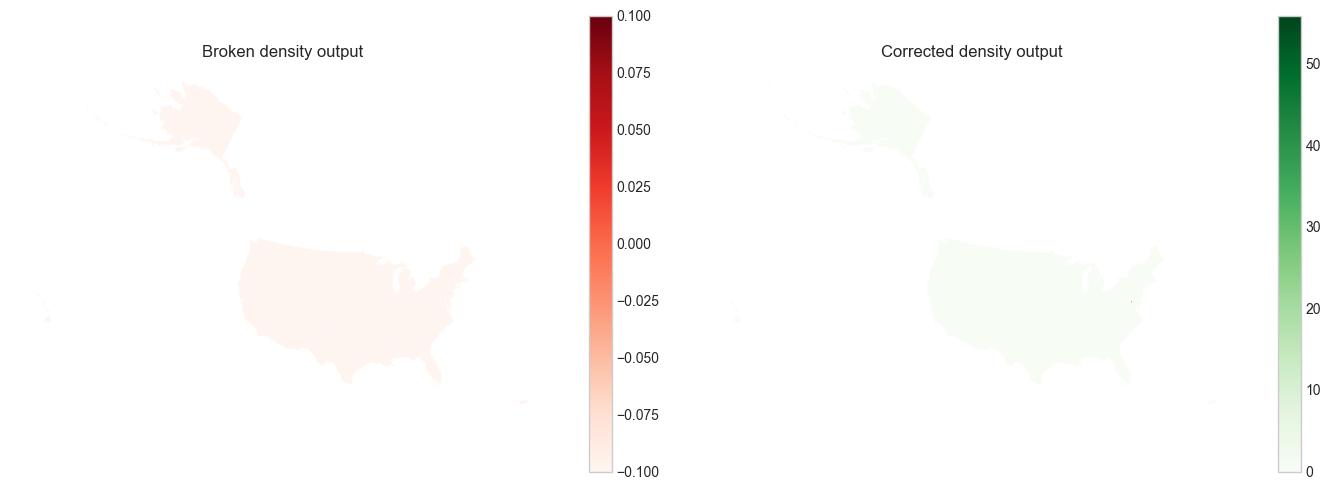

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

lab_out_bad.to_crs(5070).plot(column="density_bad", ax=ax[0], legend=True, cmap="Reds")
ax[0].set_title("Broken density output")
ax[0].set_axis_off()

lab_out_fix.to_crs(5070).plot(column="density_per_10k_sqkm", ax=ax[1], legend=True, cmap="Greens")
ax[1].set_title("Corrected density output")
ax[1].set_axis_off()

plt.tight_layout()


### 5-10 minute exercise 5

- Add one additional plausibility check to the corrected output.
- Example checks:
  - no negative density
  - density below a chosen threshold
  - contiguous US vs non-contiguous comparison
- Briefly justify your threshold/logic.

In [18]:
# Student exercise 5
# TODO: Add one more plausibility check and summarize findings


## Part 4 (15 min): Meta discussion

Discuss as a class:

- Why can't spatial validation be fully automated?
- Which checks can an AI assistant run reliably?
- Where is human geographic judgment required?
- What risks happen when we automate before validating spatial meaning?

## Optional extension: Advanced validation modules for AI-generated GIS/GeoAI code

The sections below target common failure modes in vibe-coded geospatial workflows. Each module includes:

- concept and why it matters
- supporting papers
- short code example
- 5-10 minute student exercise
- preferred answer for quick checking

### Concept 1: Data provenance and schema drift checks

**Why this matters:** AI-generated code often assumes column names, boundaries, or scales that may have changed. A workflow can run but use the wrong data vintage, schema, or coverage.

**Supporting papers:**

- Goodchild, M. F., and Li, L. (2012). Assuring the quality of volunteered geographic information. *Spatial Statistics*, 1, 110-120.
- Veregin, H. (2005). Data quality parameters. In *A Research Agenda for Geographic Information Science*.

Start every workflow with explicit source metadata and schema checks.

In [19]:
# Example: simple provenance + schema validation
source_registry = {
    "states": {
        "url": url_tiger_states,
        "expected_columns": {"STATEFP", "NAME", "geometry"},
        "expected_min_rows": 50,
        "expected_max_rows": 60
    },
    "places": {
        "url": url_ne_places,
        "expected_columns": {"name", "adm0name", "geometry"},
        "expected_min_rows": 200,
        "expected_max_rows": 10000
    }
}

def check_schema_and_size(gdf, spec):
    cols_ok = spec["expected_columns"].issubset(set(gdf.columns))
    rows_ok = spec["expected_min_rows"] <= len(gdf) <= spec["expected_max_rows"]
    return {"columns_ok": cols_ok, "rows_ok": rows_ok, "row_count": len(gdf)}

print("states check:", check_schema_and_size(states, source_registry["states"]))
print("places check:", check_schema_and_size(places, source_registry["places"]))

states check: {'columns_ok': True, 'rows_ok': True, 'row_count': 52}
places check: {'columns_ok': True, 'rows_ok': True, 'row_count': 243}


### 5-10 minute exercise A

Add one more provenance check: verify CRS is present and geographic for both raw source files.

In [20]:
# Student exercise A
# TODO: write a check that verifies `gdf.crs is not None` and CRS is geographic


In [21]:
# Preferred answer A
from pyproj import CRS

def check_raw_crs_is_geographic(gdf):
    if gdf.crs is None:
        return False
    return CRS(gdf.crs).is_geographic

print("states geographic CRS:", check_raw_crs_is_geographic(states))
print("places geographic CRS:", check_raw_crs_is_geographic(places))

states geographic CRS: True
places geographic CRS: True


### Concept 2: Sensitivity analysis for spatial choices

**Why this matters:** Small implementation choices can change outputs materially (join predicate, buffer distance, threshold rules). If results are unstable under reasonable alternatives, treat conclusions cautiously.

**Supporting papers:**

- Saltelli, A., et al. (2008). *Global Sensitivity Analysis: The Primer*.
- O'Sullivan, D., and Unwin, D. (2010). *Geographic Information Analysis* (uncertainty and sensitivity discussion).

In [22]:
# Example: compare output sensitivity to buffer distance choice
us_points_sa = places[places["adm0name"] == "United States of America"][["name", "geometry"]].to_crs(5070)
states_sa = states[["NAME", "geometry"]].to_crs(5070)

def mean_states_intersected(points_gdf, polygons_gdf, buffer_m):
    buf = points_gdf.copy()
    buf["geometry"] = buf.buffer(buffer_m)
    hits = gpd.sjoin(buf, polygons_gdf, how="left", predicate="intersects")
    per_point = hits.groupby(hits.index).size()
    return float(per_point.mean())

mean_hit_25km = mean_states_intersected(us_points_sa, states_sa, 25_000)
mean_hit_75km = mean_states_intersected(us_points_sa, states_sa, 75_000)

print({
    "mean_states_intersected_25km": mean_hit_25km,
    "mean_states_intersected_75km": mean_hit_75km,
    "absolute_difference": mean_hit_75km - mean_hit_25km,
    "pct_difference_vs_25km": (mean_hit_75km - mean_hit_25km) / max(mean_hit_25km, 1e-9)
})

{'mean_states_intersected_25km': 1.4444444444444444, 'mean_states_intersected_75km': 1.8888888888888888, 'absolute_difference': 0.4444444444444444, 'pct_difference_vs_25km': 0.30769230769230765}


### 5-10 minute exercise B

Create a rule that flags this workflow as unstable if changing buffer distance from 25 km to 75 km changes the mean intersected-state count by more than 10%.

In [23]:
# Student exercise B
# TODO: implement unstable/stable flag based on percent difference threshold


In [24]:
# Preferred answer B
threshold = 0.10
pct_diff = abs(mean_hit_75km - mean_hit_25km) / max(mean_hit_25km, 1e-9)
stability_flag = "unstable" if pct_diff > threshold else "stable"
print({"pct_diff": pct_diff, "status": stability_flag})

{'pct_diff': 0.30769230769230765, 'status': 'unstable'}


### Concept 3: Spatial leakage in train/test evaluation

**Why this matters:** Random splits can place test observations very near training observations. In spatial data this can inflate apparent performance and hide generalization failure.

**Supporting papers:**

- Roberts, D. R., et al. (2017). Cross-validation strategies for data with temporal, spatial, hierarchical, or phylogenetic structure. *Ecography*, 40(8), 913-929.
- Brenning, A. (2012). Spatial cross-validation and bootstrap for model tuning and performance estimation.

In [25]:
# Example: random split vs spatial block split separation distance
cent = states.to_crs(5070).copy()
cent["geometry"] = cent.centroid
cent = cent.reset_index(drop=True)

# Random split
rand_train = cent.sample(frac=0.7, random_state=42).copy()
rand_test = cent.drop(rand_train.index).copy()

# Spatial block split by x-coordinate median
median_x = cent.geometry.x.median()
block_train = cent[cent.geometry.x <= median_x].copy()
block_test = cent[cent.geometry.x > median_x].copy()

def median_nearest_distance(test_gdf, train_gdf):
    dists = []
    for geom in test_gdf.geometry:
        dists.append(train_gdf.distance(geom).min())
    return float(pd.Series(dists).median())

rand_med_nn_m = median_nearest_distance(rand_test, rand_train)
block_med_nn_m = median_nearest_distance(block_test, block_train)

print({
    "random_split_median_nn_km": rand_med_nn_m / 1000,
    "block_split_median_nn_km": block_med_nn_m / 1000
})

{'random_split_median_nn_km': 261.4258231953713, 'block_split_median_nn_km': 1005.3870402298443}


### 5-10 minute exercise C

Set a minimum desired separation of 150 km between train and test. Which split strategy passes this rule?

In [26]:
# Student exercise C
# TODO: evaluate both splits against a 150 km minimum nearest-neighbor separation rule


In [27]:
# Preferred answer C
min_sep_km = 150
result = {
    "random_passes": (rand_med_nn_m / 1000) >= min_sep_km,
    "block_passes": (block_med_nn_m / 1000) >= min_sep_km
}
print(result)

{'random_passes': True, 'block_passes': True}


### Concept 4: MAUP and zonation effects

**Why this matters:** Aggregated results can change when you change zone definitions, even with the same underlying points. This is a core geographic limitation, not a coding bug.

**Supporting papers:**

- Openshaw, S. (1984). *The Modifiable Areal Unit Problem*.
- Fotheringham, A. S., and Wong, D. W. S. (1991). The modifiable areal unit problem in multivariate statistical analysis. *Environment and Planning A*, 23(7), 1025-1044.

In [28]:
# Example: compare counts by country zoning vs coarse global grid zoning
world_pts = places[["name", "geometry"]].to_crs(6933)
country_polys = world[["NAME", "geometry"]].to_crs(6933)

# Country zoning
by_country = gpd.sjoin(world_pts, country_polys, how="left", predicate="within").groupby("NAME").size()
country_cv = float(by_country.std() / max(by_country.mean(), 1))

# Coarse global grid zoning
minx, miny, maxx, maxy = world_pts.total_bounds
nx, ny = 12, 6
cell_w = (maxx - minx) / nx
cell_h = (maxy - miny) / ny

from shapely.geometry import box
polys = []
ids = []
for i in range(nx):
    for j in range(ny):
        x0 = minx + i * cell_w
        y0 = miny + j * cell_h
        x1 = x0 + cell_w
        y1 = y0 + cell_h
        polys.append(box(x0, y0, x1, y1))
        ids.append(f"cell_{i}_{j}")

grid = gpd.GeoDataFrame({"zone_id": ids}, geometry=polys, crs=6933)
by_grid = gpd.sjoin(world_pts, grid, how="left", predicate="within").groupby("zone_id").size()
grid_cv = float(by_grid.std() / max(by_grid.mean(), 1))

print({"country_zone_cv": country_cv, "grid_zone_cv": grid_cv})

{'country_zone_cv': 0.6963057442322667, 'grid_zone_cv': 1.1859979321419267}


### 5-10 minute exercise D

Interpret the CV comparison in one sentence: what does it imply about sensitivity to zonation?

In [29]:
# Student exercise D
# TODO: write a one-sentence interpretation in a Python string named `maup_interpretation`


In [30]:
# Preferred answer D
maup_interpretation = (
    "Different CV values across state and grid zoning indicate the pattern summary depends on areal unit design, "
    "so reported hotspots are not zoning-invariant."
)
print(maup_interpretation)

Different CV values across state and grid zoning indicate the pattern summary depends on areal unit design, so reported hotspots are not zoning-invariant.


### Concept 5: Temporal validity checks

**Why this matters:** Spatial joins and models can silently combine variables from different years. If time does not align, causal or comparative interpretation is weakened.

**Supporting papers:**

- Peuquet, D. J. (1994). It's about time: A conceptual framework for the representation of temporal dynamics in GIS. *Annals of the AAG*, 84(3), 441-461.
- Yuan, M. (1996). Temporal GIS and spatio-temporal modeling.

In [31]:
# Example: simple temporal alignment guardrail
features = pd.DataFrame({
    "NAME": ["California", "Texas", "Florida"],
    "feature_year": [2023, 2023, 2023],
    "risk_index": [0.62, 0.54, 0.59]
})

labels = pd.DataFrame({
    "NAME": ["California", "Texas", "Florida"],
    "label_year": [2021, 2021, 2021],
    "observed_outcome": [1, 0, 1]
})

merged_time = features.merge(labels, on="NAME", how="inner")
merged_time["year_aligned"] = merged_time["feature_year"] == merged_time["label_year"]
print(merged_time)
print("all rows aligned:", bool(merged_time["year_aligned"].all()))

         NAME  feature_year  risk_index  label_year  observed_outcome  \
0  California          2023        0.62        2021                 1   
1       Texas          2023        0.54        2021                 0   
2     Florida          2023        0.59        2021                 1   

   year_aligned  
0         False  
1         False  
2         False  
all rows aligned: False


### 5-10 minute exercise E

Write an assertion that raises an error when years are not aligned.

In [32]:
# Student exercise E
# TODO: add assertion for temporal alignment


In [33]:
# Preferred answer E
# Show failing case without breaking notebook execution
try:
    assert merged_time["year_aligned"].all(), "Temporal mismatch detected: feature_year != label_year"
except AssertionError as e:
    print("Expected failure:", e)

# Then show a passing aligned case
labels_aligned = labels.copy()
labels_aligned["label_year"] = 2023
merged_time_aligned = features.merge(labels_aligned, on="NAME", how="inner")
merged_time_aligned["year_aligned"] = merged_time_aligned["feature_year"] == merged_time_aligned["label_year"]
assert merged_time_aligned["year_aligned"].all()
print("Aligned case passed")

Expected failure: Temporal mismatch detected: feature_year != label_year
Aligned case passed


### Concept 6: Reproducibility guardrails

**Why this matters:** If model outputs cannot be reproduced, validity claims are weak. Reproducibility includes data versions, library versions, and random seeds.

**Supporting papers:**

- Peng, R. D. (2011). Reproducible research in computational science. *Science*, 334(6060), 1226-1227.
- Wilson, G., et al. (2017). Good enough practices in scientific computing. *PLoS Computational Biology*, 13(6): e1005510.

In [34]:
# Example: create a compact validation report artifact
import json
import importlib.metadata as ilm

def make_validation_report(seed=42):
    return {
        "seed": seed,
        "data_urls": {
            "states": url_tiger_states,
            "places": url_ne_places
        },
        "library_versions": {
            "geopandas": ilm.version("geopandas"),
            "pandas": ilm.version("pandas"),
            "shapely": ilm.version("shapely"),
            "pyproj": ilm.version("pyproj")
        }
    }

report = make_validation_report(seed=42)
print(report)

{'seed': 42, 'data_urls': {'states': 'https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip', 'places': 'https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_populated_places_simple.zip'}, 'library_versions': {'geopandas': '1.1.2', 'pandas': '3.0.1', 'shapely': '2.1.2', 'pyproj': '3.7.2'}}


### 5-10 minute exercise F

Save the validation report to a JSON file called `validation_report_week5.json`.

In [35]:
# Student exercise F
# TODO: write report to JSON file


In [36]:
# Preferred answer F
with open("validation_report_week5.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)
print("Saved validation_report_week5.json")

Saved validation_report_week5.json


### Concept 7: LLM-generated GIS code failure modes

**Why this matters:** LLM code may be syntactically correct but geographically unsafe (wrong units, assumed CRS, invalid predicates). Build explicit guardrails before trusting outputs.

**Supporting reading:**

- Longley, P. A., et al. (2015). *Geographic Information Science and Systems* (measurement, CRS, and analytical validity).
- Use your own course notes from Weeks 1-5 as a project-specific failure mode catalog.

In [37]:
# Example: CRS suitability check before distance/area calculations
from pyproj import CRS

def require_projected_metric_crs(gdf, operation_name="measurement"):
    if gdf.crs is None:
        raise ValueError(f"{operation_name}: CRS is missing")
    crs = CRS(gdf.crs)
    if crs.is_geographic:
        raise ValueError(f"{operation_name}: CRS is geographic; project to a metric CRS first")

# Demonstration
try:
    require_projected_metric_crs(states, operation_name="area")
except ValueError as e:
    print("Expected guardrail trigger:", e)

states_5070_demo = states.to_crs(5070)
require_projected_metric_crs(states_5070_demo, operation_name="area")
print("Projected CRS check passed for EPSG:5070")

Expected guardrail trigger: area: CRS is geographic; project to a metric CRS first
Projected CRS check passed for EPSG:5070


### 5-10 minute exercise G

Use the guardrail function before computing a 10 km buffer around US populated places. Ensure the check fails in geographic CRS and passes after projection.

In [38]:
# Student exercise G
# TODO: apply guardrail before buffering and fix CRS appropriately


In [39]:
# Preferred answer G
us_points_demo = places[places["adm0name"] == "United States of America"][["name", "geometry"]]

try:
    require_projected_metric_crs(us_points_demo, operation_name="buffer")
except ValueError as e:
    print("Expected:", e)

us_points_demo_5070 = us_points_demo.to_crs(5070)
require_projected_metric_crs(us_points_demo_5070, operation_name="buffer")
buf_10km = us_points_demo_5070.copy()
buf_10km["geometry"] = buf_10km.buffer(10_000)
print("Created", len(buf_10km), "buffers of 10 km")

Expected: buffer: CRS is geographic; project to a metric CRS first
Created 9 buffers of 10 km


### Instructor note

For a strict 2-hour class, choose 2-3 extension modules based on student progress. Recommended priority: Concepts 1-4 (provenance, sensitivity, leakage, MAUP). Use Concepts 5-7 as homework or next-class bridge content.

## Exit ticket (5 minutes)

Write 3-4 sentences:

1. One spatial error you now catch automatically.
2. One invariant you plan to use in future projects.
3. One thing AI can help with, and one thing it cannot reliably decide for you.

## Optional homework extension

Create a reusable `validate_spatial_results(...)` utility for your assignment workflow and include:

- CRS compatibility checks
- Geometry validity checks
- Join match-rate checks
- Measurement projection checks
- At least one custom plausibility rule

Submit code plus one paragraph reflecting on false positives/false negatives in your validator.